[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/router_tutorial.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239412-lesson-5-router)

# Interactive Tutorial: Building Routers in LangGraph

## Learning Objectives

By the end of this tutorial, you will be able to:

1. **Understand routing concepts** - Explain how LLMs can direct control flow in applications
2. **Set up tools with chat models** - Bind tools to language models for dynamic execution
3. **Build graph nodes** - Create nodes for LLM responses and tool execution
4. **Use conditional edges** - Implement routing logic based on LLM output
5. **Create complete graphs** - Assemble all components into a functional router
6. **Test and validate** - Experiment with different inputs to understand routing behavior

## What is a Router?

A **router** is a fundamental concept in AI applications where a language model acts as a "traffic controller," deciding whether to:
- Provide a direct response to the user
- Call one or more tools to gather information or perform actions

Think of it like a smart assistant that can either answer directly from knowledge or use specific tools when needed.

![Router Concept](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

### Real-World Analogy
Imagine you're at a restaurant and ask the waiter "What time is it?" The waiter might:
1. **Direct response**: Look at their watch and tell you the time
2. **Tool call**: Use their phone to check the exact time

Similarly, our LLM router decides the best approach based on the question.

## Setup: Installing Dependencies

Let's start by installing the required packages:

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

Now let's set up our API key. You'll need an OpenAI API key to run this tutorial:

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Step 1: Understanding Tools and Function Calling

### Concept Explanation

**Tools** in LangGraph are Python functions that the LLM can call to perform specific tasks. The LLM doesn't execute the code directly - instead, it identifies when a tool should be used and provides the parameters.

### Example: Creating a Simple Tool

Let's start with a basic multiplication tool:

In [4]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# Create the LLM and bind our tool to it
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])

print("Tool created and bound to LLM successfully!")
# print(f"Available tools: {[tool.name for tool in llm_with_tools.bound]}")

Tool created and bound to LLM successfully!


### Exercise 1: Test Tool Binding

Let's test what happens when we ask the LLM a question that might require the multiply tool:

In [5]:
from langchain_core.messages import HumanMessage

# Test with a multiplication question
response = llm_with_tools.invoke([HumanMessage(content="What is 7 multiplied by 9?")])
print("Response type:", type(response))
print("Response content:", response.content)
print("Tool calls:", response.tool_calls if hasattr(response, 'tool_calls') else "None")

Response type: <class 'langchain_core.messages.ai.AIMessage'>
Response content: 
Tool calls: [{'name': 'multiply', 'args': {'a': 7, 'b': 9}, 'id': 'call_vWDAqN1WDQeR4E9DANfKMHYJ', 'type': 'tool_call'}]


In [6]:
# Now test with a non-multiplication question
response2 = llm_with_tools.invoke([HumanMessage(content="Hello! How are you today?")])
print("Response type:", type(response2))
print("Response content:", response2.content)
print("Tool calls:", response2.tool_calls if hasattr(response2, 'tool_calls') else "None")

Response type: <class 'langchain_core.messages.ai.AIMessage'>
Response content: Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?
Tool calls: []


### Reflection Questions

1. What difference did you notice between the two responses?
2. When did the LLM decide to use a tool call vs. a direct response?
3. What information is included in a tool call?

_Take a moment to think about these questions before continuing._

## Step 2: Creating Additional Tools

Let's expand our toolkit with more functions to make our router more interesting:

### Exercise 2: Create Your Own Tools

In [7]:
def add(a: int, b: int) -> int:
    """Add two numbers together.
    
    Args:
        a: first number
        b: second number
    """
    return a + b

def get_weather(city: str) -> str:
    """Get the current weather for a city.
    
    Args:
        city: name of the city
    """
    # This is a mock function - in reality, you'd call a weather API
    return f"The weather in {city} is sunny and 72°F"

# TODO: Create your own tool function here!
# Try creating a simple calculator function like subtract, divide, or power
def subtract(a:int, b:int) -> int:
    ''' 
    Subtract b from a
    '''
    return a-b

print("Additional tools created!")

Additional tools created!


### Exercise 2a: Complete the Tool

Replace the `your_tool_here` function with your own tool. Some ideas:
- `subtract(a, b)` - subtract two numbers
- `power(base, exponent)` - raise a number to a power
- `word_count(text)` - count words in a text
- `reverse_string(text)` - reverse a string

Make sure to include proper docstrings!

## Step 3: Building the Router Graph

### Concept: Graph Components

A LangGraph router consists of:

1. **Nodes**: Functions that process the state
   - `tool_calling_llm`: Node that runs the LLM and decides whether to call tools
   - `ToolNode`: Node that executes tools when called

2. **Edges**: Connections between nodes
   - Regular edges: Always go to the next node
   - Conditional edges: Route based on conditions (like tool calls)

3. **State**: The data that flows through the graph (messages in our case)

Let's build our router step by step:

In [8]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Step 1: Create the LLM with tools
tools = [multiply, add, get_weather, subtract]  # Add your tool to this list!
llm_with_tools = llm.bind_tools(tools)

print(f"LLM configured with {len(tools)} tools")

LLM configured with 4 tools


In [9]:
# Step 2: Define the LLM node
def tool_calling_llm(state: MessagesState):
    """Node that processes messages and potentially calls tools."""
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

print("LLM node defined")

LLM node defined


In [ ]:
# Step 3: Build the complete graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,  # This decides: tools if tool_calls exist, END if not
)
builder.add_edge("tools", END)

# Compile the graph
graph = builder.compile()

print("Graph built successfully!")

Graph built successfully!


### Exercise 3: Visualize the Graph

Let's see what our graph looks like:

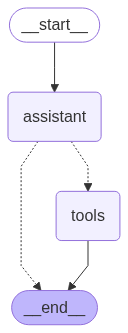

In [14]:
# Visualize the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("Graph structure:")
    print("START -> tool_calling_llm -> [conditional] -> tools OR END")
    print("tools -> END")

### Understanding the Graph Flow

1. **START** → **tool_calling_llm**: Every request begins with the LLM node
2. **tool_calling_llm** → **Conditional Edge**: 
   - If LLM output contains tool calls → go to **tools** node
   - If LLM output has no tool calls → go to **END**
3. **tools** → **END**: After executing tools, we're done

The `tools_condition` function automatically handles this routing logic!

## Step 4: Testing the Router

Now comes the fun part - let's test our router with different types of inputs!

### Exercise 4a: Test Tool-Requiring Questions

In [12]:
def test_router(question: str):
    """Helper function to test the router and display results clearly."""
    print(f"\n{'='*50}")
    print(f"QUESTION: {question}")
    print(f"{'='*50}")
    
    messages = [HumanMessage(content=question)]
    result = graph.invoke({"messages": messages})
    
    print("\nCONVERSATION FLOW:")
    for i, message in enumerate(result['messages']):
        print(f"\n{i+1}. {message.__class__.__name__}:")
        if hasattr(message, 'content') and message.content:
            print(f"   Content: {message.content}")
        if hasattr(message, 'tool_calls') and message.tool_calls:
            print(f"   Tool Calls: {message.tool_calls}")
    
    return result

# Test 1: Mathematical calculation
test_router("What is 15 multiplied by 8?")


QUESTION: What is 15 multiplied by 8?

CONVERSATION FLOW:

1. HumanMessage:
   Content: What is 15 multiplied by 8?

2. AIMessage:
   Tool Calls: [{'name': 'multiply', 'args': {'a': 15, 'b': 8}, 'id': 'call_GPRhtb4tXV71uha0mUWlq9B7', 'type': 'tool_call'}]

3. ToolMessage:
   Content: 120


{'messages': [HumanMessage(content='What is 15 multiplied by 8?', additional_kwargs={}, response_metadata={}, id='15723a47-ea80-45c5-a801-e1dfe993c988'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GPRhtb4tXV71uha0mUWlq9B7', 'function': {'arguments': '{"a":15,"b":8}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 141, 'total_tokens': 158, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-CAeMVwAPkXslquehUsqT6LbOu29M2', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--335f5361-6f85-44d4-abff-12590247f00b-0', tool_calls=[{'name': 'multiply', 'args': {'a': 15, 'b': 8}, 'id': 'call_GPRhtb4tXV71u

In [ ]:
# Test 2: Addition
test_router("Please add 25 and 37")

In [ ]:
# Test 3: Weather query
test_router("What's the weather like in San Francisco?")

### Exercise 4b: Test Direct Response Questions

In [ ]:
# Test 4: General greeting
test_router("Hello! How are you doing today?")

In [ ]:
# Test 5: General knowledge question
test_router("What is the capital of France?")

In [ ]:
# Test 6: Explanation request
test_router("Can you explain what machine learning is?")

### Exercise 4c: Interactive Testing

Now it's your turn! Try your own questions:

In [ ]:
# Try your own questions here!
# Some ideas:
# - "What is 12 + 88?" (should use add tool)
# - "Tell me a joke" (should respond directly)
# - "What's the weather in Tokyo?" (should use weather tool)
# - "What is your favorite color?" (should respond directly)

your_question = "What is 12 + 88?"  # Replace with your own question
test_router(your_question)

## Step 5: Understanding Router Behavior

### Analysis Questions

Based on your tests, answer these questions:

1. **Pattern Recognition**: What patterns do you notice in when the router chooses tools vs. direct responses?

2. **Tool Selection**: How does the LLM decide which specific tool to use when multiple tools are available?

3. **Message Flow**: What types of messages do you see in the conversation when tools are called?

### Expected Behavior

The router should:
- **Use tools** for specific computational tasks (math, weather lookup)
- **Respond directly** for general conversation, knowledge questions, and explanations
- **Choose the right tool** based on the task type
- **Show the complete flow** including tool calls and their results

## Step 6: Advanced Exercises

### Exercise 6a: Error Handling

What happens if we ask for something our tools can't handle?

In [ ]:
# Test error handling
test_router("Can you divide 10 by 2?")

### Exercise 6b: Multiple Operations

Can our router handle requests that might need multiple tools?

In [ ]:
# Test complex requests
test_router("What is 5 times 7, and also what's the weather in New York?")

### Exercise 6c: Edge Cases

Let's test some edge cases:

In [ ]:
# Test with numbers in text that don't need calculation
test_router("I have 5 cats and 3 dogs. Tell me about pet care.")

In [ ]:
# Test with ambiguous mathematical language
test_router("What do you think about the product of innovation and creativity?")

## Step 7: Building Your Own Enhanced Router

### Challenge Exercise: Create an Enhanced Router

Now it's time to build your own enhanced version! Create a router with at least 5 different tools.

#### Requirements:
1. Include at least 5 tools of different types
2. Test with various inputs
3. Document what each tool does
4. Show examples of both tool calls and direct responses

#### Suggested Tools:
- Mathematical operations (subtract, divide, power, etc.)
- String operations (reverse, uppercase, word_count)
- Data operations (average, max, min from a list)
- Date/time operations (current_date, days_between)
- Mock API calls (weather, stock prices, currency conversion)


In [ ]:
# Your enhanced router here!

def subtract(a: int, b: int) -> int:
    """Subtract b from a."""
    return a - b

def word_count(text: str) -> int:
    """Count the number of words in the text."""
    return len(text.split())

def reverse_string(text: str) -> str:
    """Reverse the given string."""
    return text[::-1]

# TODO: Add 2 more tools of your choice!

# Create your enhanced router
enhanced_tools = [multiply, add, subtract, word_count, reverse_string]  # Add your tools here
enhanced_llm = llm.bind_tools(enhanced_tools)

def enhanced_tool_calling_llm(state: MessagesState):
    """Enhanced LLM node with more tools."""
    response = enhanced_llm.invoke(state["messages"])
    return {"messages": [response]}

# Build enhanced graph
enhanced_builder = StateGraph(MessagesState)
enhanced_builder.add_node("tool_calling_llm", enhanced_tool_calling_llm)
enhanced_builder.add_node("tools", ToolNode(enhanced_tools))
enhanced_builder.add_edge(START, "tool_calling_llm")
enhanced_builder.add_conditional_edges("tool_calling_llm", tools_condition)
enhanced_builder.add_edge("tools", END)

enhanced_graph = enhanced_builder.compile()

print(f"Enhanced router created with {len(enhanced_tools)} tools!")

In [ ]:
# Test your enhanced router
def test_enhanced_router(question: str):
    """Test the enhanced router."""
    messages = [HumanMessage(content=question)]
    result = enhanced_graph.invoke({"messages": messages})
    
    print(f"\nQ: {question}")
    print(f"A: {result['messages'][-1].content}")
    return result

# Test cases for your enhanced router
test_enhanced_router("What is 100 minus 37?")
test_enhanced_router("How many words are in 'The quick brown fox jumps over the lazy dog'?")
test_enhanced_router("Can you reverse the word 'hello'?")
test_enhanced_router("What is artificial intelligence?")  # Should respond directly

## Step 8: Key Takeaways and Next Steps

### Summary

Congratulations! You've successfully built and tested LangGraph routers. Here's what you've learned:

#### Core Concepts Mastered:
1. **Router Pattern**: LLMs can intelligently route between direct responses and tool calls
2. **Tool Integration**: Functions can be bound to LLMs for dynamic execution
3. **Graph Architecture**: Nodes, edges, and conditional logic work together
4. **State Management**: Messages flow through the graph maintaining conversation context
5. **Conditional Edges**: `tools_condition` automatically routes based on LLM output

#### Key Components:
- **MessagesState**: Maintains conversation history
- **ToolNode**: Executes tool calls automatically
- **tools_condition**: Built-in routing logic
- **Conditional edges**: Enable dynamic flow control

### Real-World Applications

Routers are fundamental to building:
- **AI Assistants**: Route between knowledge and tools
- **Chatbots**: Handle both conversation and actions
- **Agent Systems**: Enable complex multi-step workflows
- **API Orchestrators**: Route requests to appropriate services

### Next Steps

Ready to go further? Try these advanced topics:

1. **Multiple Router Chains**: Create routers that call other routers
2. **Memory Integration**: Add persistent memory to your routers
3. **Custom Conditional Logic**: Write your own routing conditions
4. **Error Handling**: Add robust error handling and recovery
5. **Streaming Responses**: Implement real-time response streaming
6. **Multi-Agent Systems**: Coordinate multiple AI agents

### Final Challenge

Build a "Smart Assistant" router that can:
- Handle calculations (multiple math operations)
- Answer general questions directly
- Look up information (weather, definitions, etc.)
- Process text (analyze, transform, summarize)
- Remember conversation context

**Good luck with your LangGraph journey!**

### Reflection Exercise

Before finishing, take a moment to reflect on your learning:

1. **What was the most surprising thing you learned about routers?**

2. **Which part was most challenging to understand?**

3. **What real-world application would you like to build with routers?**

4. **What questions do you still have about LangGraph routers?**

_Write your thoughts in the cell below:_

### Your Reflections:

_Replace this text with your thoughts about the tutorial..._

1. Most surprising: 
2. Most challenging: 
3. Real-world application idea: 
4. Questions remaining: 
